In [3]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd

In [4]:
data_1km = pd.read_csv('data/1km_data.csv')
X = np.array(data_1km[['long', 'lat']])
Y = np.array(data_1km['generated_temp']).reshape(-1,1)
print(X.shape, Y.shape)

(3742312, 2) (3742312, 1)


In [5]:
# generate random data (replace this with your actual data)
n_samples = 500

import numpy as np
X = np.random.random((n_samples, 20)) # X data has 20 features
Y = np.random.random((n_samples, 3))  # Y data has only 3 features

# print the data shape
# both data sets should be in the shape (n_samples, n_features)
print(X.shape)
print(Y.shape)

(500, 20)
(500, 3)


In [6]:
# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 32,
                    'n_epochs'    : 30,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'learning_rate' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : False,
                    'save_filepath': 'sample_results/experiment0001/trained_blocks/CondDensityEstimator/best_weights.weights.h5',
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 4},
                         'verbose' : 0
}
effect_cluster_params = {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 2},
                         'verbose' : 0
}

In [7]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer', 'EffectClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params, effect_cluster_params]

results_path = 'sample_results' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

save_path 'sample_results' doesn't exist, creating now.
All results from this run will be saved to sample_results/experiment0000
Block: verbose not specified in input, defaulting to 1
CondExpBase: save_filepath specified but not used by this block type
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: early_stopping not specified in input, defaulting to False
CondExpBase: checkpoint

#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/30
12/12 [==============================] - 1s 18ms/step - loss: 0.9549 - val_loss: 0.9291
Epoch 2/30
12/12 [==============================] - 0s 4ms/step - loss: 0.8797 - val_loss: 0.8545
Epoch 3/30
12/12 [==============================] - 0s 4ms/step - loss: 0.8089 - val_loss: 0.7850
Epoch 4/30
12/12 [==============================] - 0s 4ms/step - loss: 0.7425 - val_loss: 0.7203
Epoch 5/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6807 - val_loss: 0.6604
Epoch 6/30
12/12 [==============================] - 0s 4ms/step - loss: 0.6239 - val_loss: 0.6045
Epoch 7/30
12/12 [==============================] - 0s 4ms/step - loss: 0.5709 - val_loss: 0.5528
Epoch 8/30
12/12 [==============================] - 0s 4ms/step - loss: 0.5222 - val_loss: 0.5049
Epoch 9/30
12/12 [==============================] - 0s 4ms/step - loss:

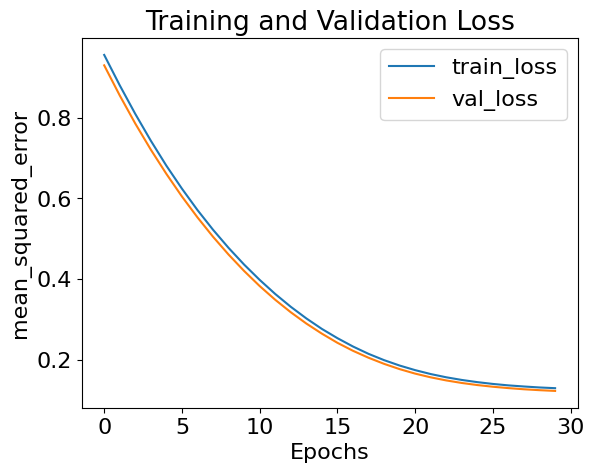

16/16 [==============================] - 0s 1ms/step
Saving parameters to  sample_results/experiment0000/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Beginning EffectClusterer training...


100%|██████████| 500/500 [00:00<00:00, 8341.69it/s]

EffectClusterer training complete.
Experiment training complete.


In [8]:
results = my_exp.train()